In [23]:
import os    
#os.environ['THEANO_FLAGS'] = "device=gpu1"  
#os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu0,floatX=float32,lib.cnmem=1"
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=gpu0,floatX=float32"
import theano
import numpy as np
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import *

from sklearn.cross_validation import train_test_split

%matplotlib inline

# this is the size of our encoded representations
#encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats
#encoding_dim = 3
encoding_dim = 40


# this is our input placeholder
input_img = Input(shape=(3072,))

# "encoded" is the encoded representation of the input
# Just a single hidden layer fully connected shallow network architecture
encoded = Dense(1500, activation='relu')(input_img)  #18X18


encoded = Dense(encoding_dim, activation='relu')(encoded)

# "decoded" is the lossy reconstruction of the input

decoded = Dense(3072, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input=input_img, output=decoded)


In [24]:
print (encoding_dim)
print (input_img)
print (encoded)
print (decoded)
print (autoencoder)

40
input_3
Elemwise{mul,no_inplace}.0
sigmoid.0


In [25]:
# this model maps an input to its encoded representation
encoder = Model(input=input_img, output=encoded)

In [26]:
print (encoder)

In [27]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(input=encoded_input, output=decoder_layer(encoded_input))

In [28]:
print (encoded_input)
print (decoder_layer)
print (decoder)

input_4


In [29]:
#autoencoder.compile(optimizer=Adam(lr=0.00001), loss='categorical_crossentropy') #around 35.47% test accuracy
autoencoder.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy']) #around 40% test accuracy
#autoencoder.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy') #around 10% test accuracy
#autoencoder.compile(optimizer=Adam(lr=0.002), loss='categorical_crossentropy') #around 10% test accuracy

In [30]:
X_train=np.load('/media/mrafi123/UStore/Dimensionality-Reduction/data/CIFAR10/X_train.npy')
X_test=np.load('/media/mrafi123/UStore/Dimensionality-Reduction/data/CIFAR10/X_test.npy')
y_train=np.load('/media/mrafi123/UStore/Dimensionality-Reduction/data/CIFAR10/y_train.npy')
y_test=np.load('/media/mrafi123/UStore/Dimensionality-Reduction/data/CIFAR10/y_test.npy')

In [31]:
print (X_train.shape)
print (y_train.shape)
print (X_test.shape)
print (y_test.shape)

(50000, 32, 32, 3)
(50000,)
(10000, 32, 32, 3)
(10000,)


In [32]:
x_train = X_train.astype('float32') / 255.
x_test = X_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print (x_train.shape)
print (x_test.shape)

(50000, 3072)
(10000, 3072)


In [33]:
s_train, s_valid = train_test_split(x_train, test_size=0.2)

In [34]:
autoencoder.fit(s_train, s_train,
                nb_epoch=50,
                batch_size=256,
                shuffle=True,
                validation_data=(s_valid, s_valid))

Train on 40000 samples, validate on 10000 samples
Epoch 1/50
40000/40000 [==============================] - 11s - loss: 11669.3521 - acc: 9.5000e-04 - val_loss: 11599.0825 - val_acc: 8.0000e-04
Epoch 2/50
40000/40000 [==============================] - 11s - loss: 11630.8564 - acc: 0.0018 - val_loss: 11571.4064 - val_acc: 0.0022
Epoch 3/50
40000/40000 [==============================] - 11s - loss: 11610.3413 - acc: 0.0017 - val_loss: 11557.8351 - val_acc: 0.0014
Epoch 4/50
40000/40000 [==============================] - 11s - loss: 11601.1307 - acc: 0.0025 - val_loss: 11551.3615 - val_acc: 0.0023
Epoch 5/50
40000/40000 [==============================] - 11s - loss: 11596.0218 - acc: 0.0032 - val_loss: 11547.1668 - val_acc: 0.0029
Epoch 6/50
40000/40000 [==============================] - 11s - loss: 11592.0728 - acc: 0.0032 - val_loss: 11543.0875 - val_acc: 0.0039
Epoch 7/50
40000/40000 [==============================] - 11s - loss: 11588.5643 - acc: 0.0033 - val_loss: 11540.5827 - val_ac

In [35]:
print (autoencoder.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 3072)          0                                            
____________________________________________________________________________________________________
dense_4 (Dense)                  (None, 1500)          4609500     input_3[0][0]                    
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 40)            60040       dense_4[0][0]                    
____________________________________________________________________________________________________
dense_6 (Dense)                  (None, 3072)          125952      dense_5[0][0]                    
Total params: 4795492
_____________________________________________________________________

In [36]:
print (encoder.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 3072)          0                                            
____________________________________________________________________________________________________
dense_4 (Dense)                  (None, 1500)          4609500     input_3[0][0]                    
____________________________________________________________________________________________________
dense_5 (Dense)                  (None, 40)            60040       dense_4[0][0]                    
Total params: 4669540
____________________________________________________________________________________________________
None


In [37]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
print (encoded_imgs.size)
print (encoded_imgs.shape)
print (encoded_imgs.nbytes)


decoded_imgs = decoder.predict(encoded_imgs)
print (decoded_imgs.size)
print (decoded_imgs.shape)
print (decoded_imgs.nbytes)

400000
(10000, 40)
3200000
30720000
(10000, 3072)
245760000


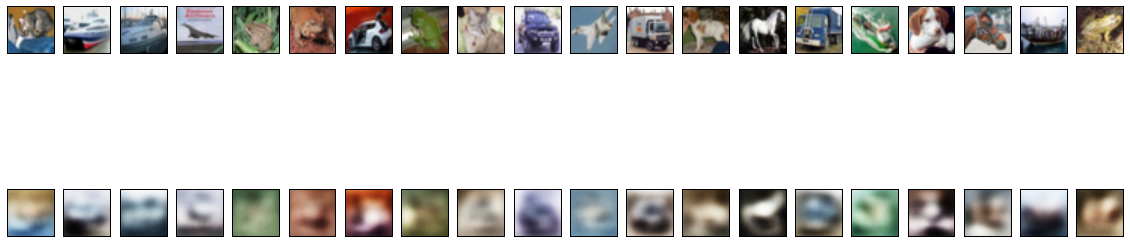

In [38]:
import matplotlib.pyplot as plt

n = 20  # how many digits we will display
plt.figure(figsize=(20, 6))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(32,32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display encoded
    #ax = plt.subplot(2, n, i + 1 + n)
    #plt.imshow(encoded_imgs[i].reshape(6, 6))
    #plt.gray()
    #ax.get_xaxis().set_visible(False)
    #ax.get_yaxis().set_visible(False)
   
    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(32,32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [39]:
#Predict the digits using a classifier
#Use the reduce Encoded train and test images
encoded_train_imgs = encoder.predict(x_train)
print (encoded_train_imgs.size)
print (encoded_train_imgs.shape)
print (encoded_train_imgs.nbytes)


2000000
(50000, 40)
16000000


In [40]:
encoded_test_imgs = encoder.predict(x_test)
print (encoded_test_imgs.size)
print (encoded_test_imgs.shape)
print (encoded_test_imgs.nbytes)

400000
(10000, 40)
3200000


In [41]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=4)
clf = clf.fit(encoded_train_imgs, y_train)

In [42]:
y_pred = clf.predict(encoded_test_imgs)


In [43]:
num=len(encoded_test_imgs)
r=0
w=0
for i in range(num):
        #print ('y_pred ',y_pred[i])
        #print ('labels ',labels[i])
        #without the use of all() returns error truth value of an array with more than one element is ambiguous
        #if y_pred[i].all() == labels[i].all():
        if np.array_equal(y_pred[i],y_test[i]):
            r+=1
        else:
            w+=1
print ("tested ",  num, "digits")
print ("correct: ", r, "wrong: ", w, "error rate: ", float(w)*100/(r+w), "%")
print ("got correctly ", float(r)*100/(r+w), "%")


tested  10000 digits
correct:  3942 wrong:  6058 error rate:  60.58 %
got correctly  39.42 %
